# README

   This repository is for the first project of the *Udacity Robotics Nanodegree*. The projects goal was to navigate through a virtual Mars terrain with a rover by processing images recorded from the rover's onboard camera. The project utilizes perspective transforms, and the rotation and translation of images. The manipulation of images were to highlight directions, obstacles, and rocks for the rover to explore. A map of the navigable terrain was developed through these distorted images.The document **Rover_Project_Test_Notebook** goes into great depths of how the aforementioned tasks were accomplished using Python. The rover's image processing can be seen in **perception.py** in the repository.

   Once an image was processed, a decision by the robot had to be made for it to continue. These decisions were based off the information created by the **perception.py** code, and can be seen in **decision.py**. Both **perception.py** & **decision.py** were accessed by the code **drive_rover.py**, which initalizes the RoverState() class and connects to the Unity software. The final project was able to explore over 50% of the map and collect 2 rock samples on an average run.This README will further address how the following repository met the *Udacity Robotic Nanodegree*'s rubric by exploring the code of the **Rover_Project_Test_Notebook**, **perception.py** and **decision.py**.

## Rover_Project_Test_Notebook

  This notebook outlines the basis of the functions used in the **perception.py**.
  

### Rock Sample

A Rock sample was identified by performing a perspective transform on the image. The image was threshed at a different RGB level (> 100,> 100,< 10). This highlighted the yellow in the image. The image was then pushed through simlar functions to get a direction to the rock sample. 

In [2]:
#find the rocks, filters for yellow
def color_thresh1(img, rgb_thresh=(100, 100, 10)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all thre threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select  

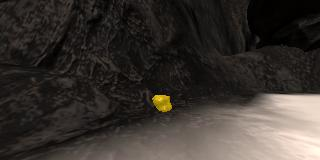

In [28]:
from IPython.core.display import Image
Image(filename='C:/Users/glenn/OneDrive/Documents/GitHub/RoboND-Rover-Project/calibration_images/example_rock2.jpg')


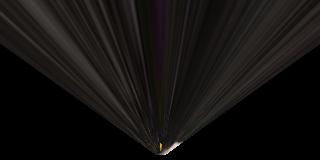

In [27]:
Image(filename='C:/Users/glenn/OneDrive/Documents/GitHub/RoboND-Rover-Project/calibration_images/warped_example1.jpg')

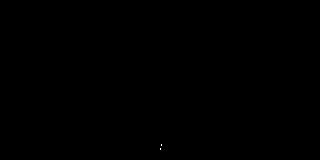

In [26]:
Image(filename='C:/Users/glenn/OneDrive/Documents/GitHub/RoboND-Rover-Project/calibration_images/warped_threshed1.jpg')


### def process_image(img):

This part of the code called on the important transformation function to finally create information for our rover to move. The image had a perspective transform applied, then had its color thressed to highlight navigable terain. The navigable terrain was then changed into rover coordinates and had polar coordinates solved also (polar coordinates are used to define the rovers direction). Finally the image was then translated and scaled to begin tracing a map.

A sample video of one the rover's manual runs were analysed with this function. 

In [29]:
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    rover_yaw = data.yaw[data.count]
    rover_xpos = data.xpos[data.count]
    rover_ypos = data.ypos[data.count]
    #print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # TODO: 
    # 1) Define source and destination points for perspective transform
    dst_size = 5 
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    # this is just a rough guess, feel free to change it!
    bottom_offset = 6
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
    # 2) Apply perspective transform
    warped = perspect_transform(grid_img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed = color_thresh(warped)
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix, ypix = rover_coords(threshed)
    dist, angles = to_polar_coords(xpix, ypix)
    mean_dir = np.mean(angles)
    # 5) Convert rover-centric pixel values to world coords
    scale = 100
    # Get navigable pixel positions in world coords
    x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                rover_ypos, rover_yaw, 
                                data.worldmap.shape[0], scale)
    # Add pixel positions to worldmap
    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[y_world,x_world, 0] += 255

    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.1, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [33]:
import io
import base64
from IPython.display import HTML
video = io.open('C:/Users/glenn/OneDrive/Documents/GitHub/RoboND-Rover-Project/output/test_mapping.mp4', 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

# perception.py

Essentially this function is completing the exacty same goal as the previous notebook, by processing the images of the onboard rover camera. Important things to note, is that a direction and angle to a rock sample is returned via Rover.samples_pos. A new object for the class was created to better steer the rover to the rocks for pick up. The distance of the rock to the rover is recorded via Rover.distance. This matrix is analyzed in the **decision.py** function. 

In [ ]:
    #image processing for rock samples
    xpix, ypix = rover_coords(threshed1)
    dist, angles = to_polar_coords(xpix, ypix)
    mean_dir = np.mean(angles)    
    scale = 100
       # plotting location of rocks
    x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, 
                                   rover_ypos, rover_yaw,  
                                   Rover.worldmap.shape[0], scale)   
    
    #Send rock position information

    Rover.samples_pos=[dist,angles]
    #Returns distance of rock to rover
    if dist.any():
        Rover.distance=dist[0]    

# decision.py

Modifications to this part of the code was to help correctly maneuver the terrain and find rock samples. Using the Rover.samples_pos object created, a direction is sent to the rover when a rock is found. When a certain pixel distance away it will stop and pick up the sample

In [ ]:
       #picking up the rocks
        Rover.steer=np.clip(np.mean(Rover.samples_pos[1]*180/np.pi),-15,15)
        Rover.mode=='forward'
        Rover.throttle=0

        if Rover.distance<14:               
            Rover.throttle = 0
            # Set brake to stored brake value
            Rover.brake = Rover.brake_set
            Rover.steer = 0
            Rover.mode = 'stop'
            Rover.near_sample=1
            Rover.samples_found=Rover.samples_found+1
            
        # If in a state where want to pickup a rock send pickup command
    if Rover.near_sample and Rover.vel == 0 and not Rover.picking_up:
        Rover.send_pickup = True
        Rover.near_sample=0

Also a timing feature was added to properly view how long the rover has been stuck. When this time limit has reached it limit, the rover is set to Stop mode and steers a direction to try to wiggle it way from being stuck. 

In [ ]:
if Rover.vel <= 0.2 and (Rover.total_time-Rover.time_stopped)>5:
    Rover.throttle = 0
    # Set brake to stored brake value
    Rover.brake = Rover.brake_set
    Rover.steer = 0
    Rover.mode = 'stop'
    Rover.time_stopped=Rover.total_time
    Rover.stuck=1
    Rover.stuck_yaw=Rover.yaw

The code ran with a screen resolution of 720 x 576 & graphics quality= good. On average the rover picked up 2 rocks and explored %80 of the map with %60 percent fidelity.